## B - Multi-dimensional posteriors and corner plots

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: We discuss how 2-dimensional (or higher) posteriors are trained and visualized.

**Key take-away messages**: Understand the meaning of `swyft.LogRatioEstimator_1dim` and `swyft.LogRatioEstimator_Ndim` arguments, `num_features`, `num_params`, and `marginals`.

### Code

In [1]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

Let's consider an example with 3 model parameters $\mathbf{z}$

$$
x = (z[0]^2 + z[1]^2 + 0.5*z[0]*z[1]*z[2])^{1/2} + \epsilon
$$

where $z[i]$ have a Uniform prior $z[i] \sim \mathcal{U}(-1, 1)$ and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the 1d and 2d posteriors for parameters $\mathbf{z}$ given a measurement of parameter $x$.

In [19]:
N = 10000  # Number of samples
z = np.random.rand(N, 3)*2 - 1
r = (z[:,0]**2 + z[:,1]**2 + 0.5*z[:, 0]*z[:,1]*z[:,2])**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.05
samples = swyft.Samples(x = x, z = z)

Let us visualize some data.

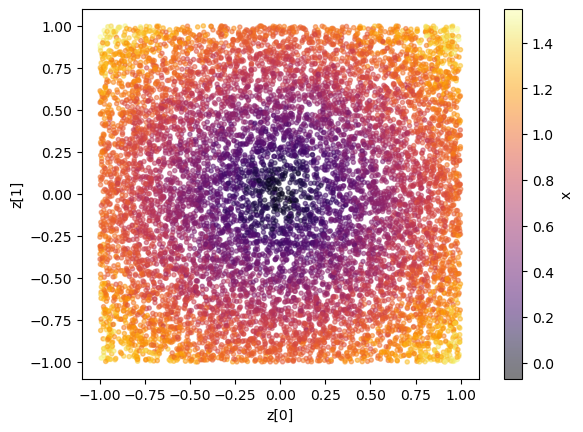

In [20]:
plt.scatter(z[:,0], z[:,1], c=x[:,0], marker='.', alpha = 0.5, cmap = 'inferno'); plt.xlabel("z[0]"); plt.ylabel("z[1]"); plt.colorbar(label = 'x');

Again, we could also take a look at the joint and marginal samples to get a feeling for the classification that will happen (although in the multidimensional example, it does not guarantee constraining power in the 1d marginals as there could be degeneracies). We can compare this to the results below to sanity check e.g. the sensitvity.

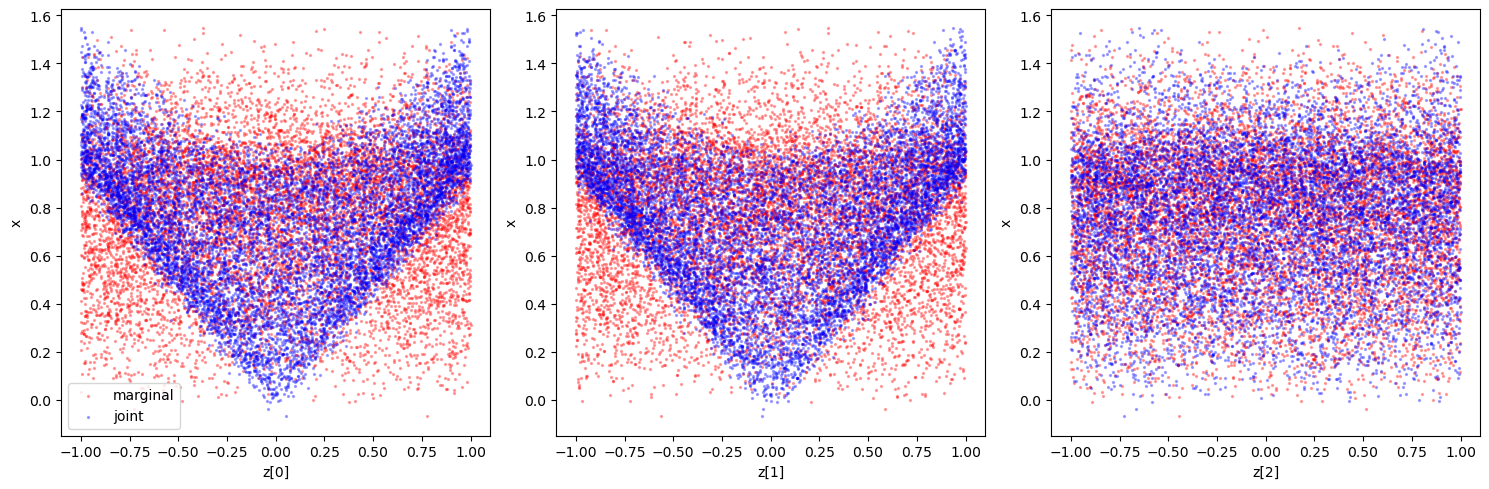

In [21]:
idx_arr = np.linspace(0, len(z) - 1, len(z), dtype=np.int32)
np.random.shuffle(idx_arr)
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.scatter(z[idx_arr, 0], x[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(z[:, 0], x[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel('z[0]')
plt.ylabel('x')
plt.legend()
ax = plt.subplot(1, 3, 2)
plt.scatter(z[idx_arr, 1], x[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(z[:, 1], x[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel('z[1]')
plt.ylabel('x')
ax = plt.subplot(1, 3, 3)
plt.scatter(z[idx_arr, 2], x[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(z[:, 2], x[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel('z[2]')
plt.ylabel('x')
plt.tight_layout()

In this example we use Swyft default networks. 
- The first network, as seen in the previous example, is `swyft.LogRatioEstimator_1dim` that we use to estimate one-dimensional posteriors. In the present example, we set the length of the parameter vector (`num_params`) to 3, since we are interested in the three 1d posteriors for each of the $\mathbf{z}$ parameters, and data vectors (`num_features`) to one, since we pass the ratio estimator $x$.
- The second network is `swyft.LogRatioEstimator_Ndim`, a dense network for estimating multi-dimensional posteriors. In particular, in the present example we are interested in the estimating the 2d marginal posterior between parameters $z[0]$ and $z[1]$ (`marginals=((0, 1),)`) given the data point $x$ (`num_features=1`).

In [22]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1),)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z', num_blocks = 4)
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 1, marginals = marginals, varnames = 'z', num_blocks = 4)

    def forward(self, A, B):
        logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios1, logratios2

Inference is the essentially done as described in Chapter A.

In [23]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 103 K 
1 | logratios2 | LogRatioEstimator_Ndim | 34.6 K
------------------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
1.106     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_21/checkpoints/epoch=25-step=6500.ckpt


In [24]:
x0 = 0.5
obs = swyft.Sample(x = np.array([x0]))
prior_samples = swyft.Samples(z = np.random.rand(1_000_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

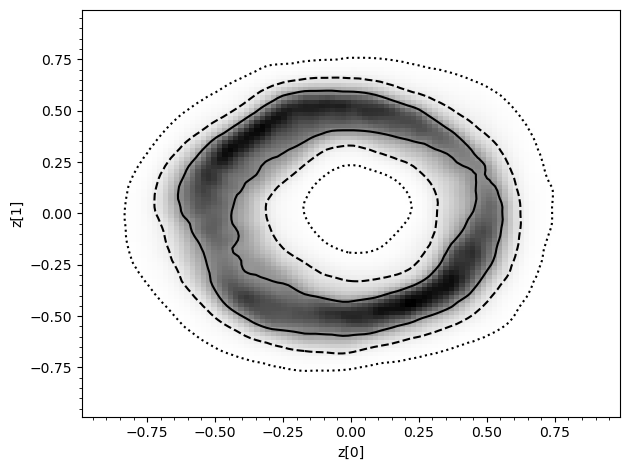

In [32]:
swyft.plot_pair(predictions, ["z[0]", "z[1]"], bins = 100, smooth = 1);

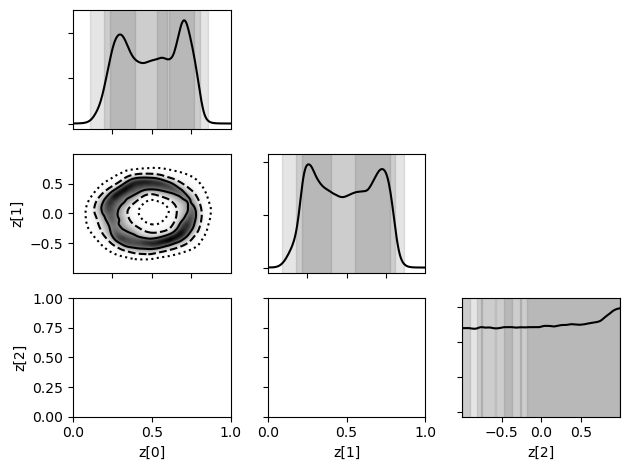

In [26]:
swyft.plot_corner(predictions, ['z[0]', 'z[1]', 'z[2]'], bins = 200, smooth = 3);

### Exercises


1. Extract information from `predictions`. What lenght is it? What types of `LogRatioSamples` does it contain? What is the shape of `logratios` and `params`?

In [27]:
# Results go here

2. Provide only partial information when making inference plot.

In [28]:
# Results go here

3. Extend above example to estimate all marginal posteriors.

In [13]:
# Results go here